In [ ]:
import latent_space
import output
from histology_main import get_session,close_session
import constants
from utils import change_active_config, natural_keys
from evaluation import load_graph, read_tensor_from_image_file, load_labels
import dcgan_alt as dcgan

#otros
import os
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import random
from importlib import reload
import imageio
from glob import glob
%matplotlib inline

# Aritmetica de vectores conceptuales con imagenes histólogicas nivel 1

Comenzamos cambiando la configuracion activa

In [2]:
dataset = "camelyon_17_16_level1"
change_active_config(dataset)
reload(constants)

<module 'constants' from '/home/ruben/Repositories/histo_bkp/histology_dcgan/constants.py'>

Y utilizamos este funcion que hemos definido para obtener una sesion de tensorflow y poder usarla nuestra arquitectura y el modelo ya entrenado. El numero que se muestra es el numero de iteraciones con las que se guardo el checkpoint

In [3]:
session, input_real, input_z, input_g_y= get_session(1)
z_batch_tensor = tf.random.uniform(
        (constants.BATCH_SIZE, constants.Z_NOISE_DIM), dtype=tf.float32, minval=-1, maxval=1)

prefix = "histo_"

INFO:tensorflow:Restoring parameters from /home/ruben/Master/camelyon_17_16_level1/checkpoints/model-66000
66000


Para poder realizar la aritmetica necesitamos primero generar algunas muestras. Las identificamos con el prefijo _histo de manera que las podamos borrar y mostrar posteriormente

In [4]:
#Borramos las muestras de generaciones anteriores
[os.remove(file) for file in glob(constants.FULL_OUTPUT_PATH+"*"+prefix+"*.*")]
#Generamos unas 3000 imagenes (32*100)
labels = np.random.randint(0,2,constants.BATCH_SIZE)
labels = np.eye(2)[labels]
output.generate_samples(session, z_batch_tensor, input_z, input_g_y, labels, constants.BATCH_SIZE * 100, save_tensor=True, name_prefix=prefix)

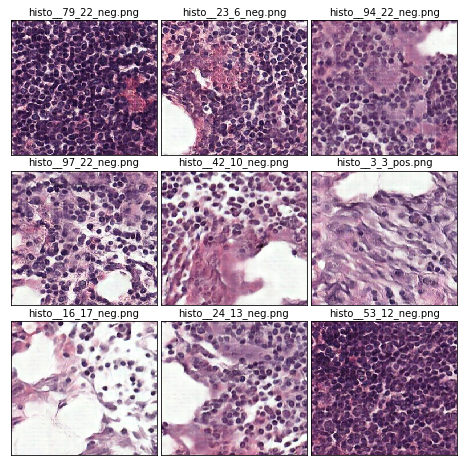

In [5]:
all_files = glob(constants.FULL_OUTPUT_PATH + "*" + prefix + "*.png")
files_to_show = random.sample(all_files,9)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(hspace=0.12, wspace=0.03)
for i,img_file in enumerate(files_to_show):
    img = plt.imread(img_file)
    plt.subplot(3, 3, i+1).set_title(img_file.split("/")[-1]).set_fontsize(10)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])
    i=i+1

### Invertir el vector de etiquetas. Cambio de clase de una muestra, condicionando el sistema de manera que usemos el mismo tensor pero con la etiqueta de otra clase.

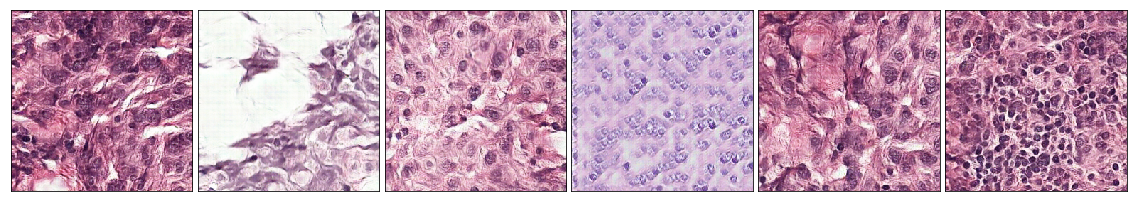

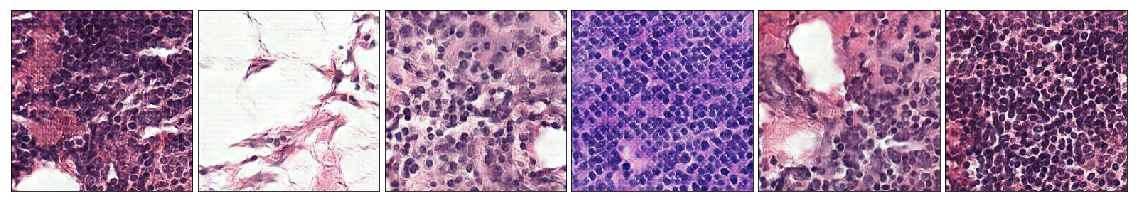

In [38]:
def show(labels):
    plt.figure(figsize=(20, 20))
    plt.subplots_adjust(hspace=0.2, wspace=0.03)
    for i,img in enumerate(tensors):
        img = np.expand_dims(img,0)
        z_ = tf.placeholder(tf.float32, [1, constants.Z_NOISE_DIM])

        samples = session.run(dcgan.sampler(z_,input_g_y,1), feed_dict={z_: img,input_g_y:labels})
        img = np.squeeze(samples)
        subplt = plt.subplot(1, 6, i+1)
        plt.imshow(img / 2 + 0.5)
        plt.xticks([])
        plt.yticks([])
        
cancer_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__70_2_pos.txt')
cancer_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__0_9_pos.txt')
cancer_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__0_24_pos.txt')
normal_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_5_neg.txt')
normal_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__33_13_neg.txt')
normal_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__70_29_neg.txt')

tensors = [cancer_1,cancer_2,cancer_3,
           normal_lumen_1,normal_lumen_2,normal_lumen_3]        

labels = [1] 
labels = np.eye(2)[labels]
show(labels)
labels = [0] 
labels = np.eye(2)[labels]
show(labels)

### Sumas, restas y medias de vectores.

Seleccionamos 3 imágenes negativas y en los que se vea el lumen, otras 3 que no sean compactas y donde no se vea, y otras 3 cancerosas también sin lumen. Vamos a realizar la operacion 3 - 3 + 3 para obtener una imagen cancerosa con lumen.

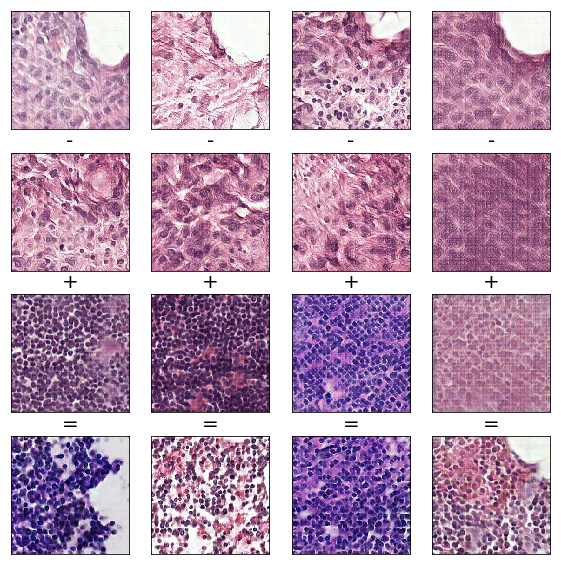

In [51]:
cancer_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__70_25_pos.txt')
cancer_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__1_9_pos.txt')
cancer_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_2_pos.txt')

cancer_no_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__2_20_pos.txt')
cancer_no_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__1_26_pos.txt')
cancer_no_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__2_2_pos.txt')

normal_no_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_4_neg.txt')
normal_no_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_8_neg.txt')
normal_no_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_5_neg.txt')

resultado_1 = cancer_lumen_1 - cancer_no_lumen_1 + normal_no_lumen_1
resultado_2 = cancer_lumen_2 - cancer_no_lumen_2 + normal_no_lumen_2
resultado_3 = cancer_lumen_3 - cancer_no_lumen_3 + normal_no_lumen_3

cancer_lumen = latent_space.average_tensor([cancer_lumen_1,cancer_lumen_2,cancer_lumen_3])
cancer_no_lumen = latent_space.average_tensor([cancer_no_lumen_1,cancer_no_lumen_2,cancer_no_lumen_3])
normal_no_lumen = latent_space.average_tensor([normal_no_lumen_1,normal_no_lumen_2,normal_no_lumen_3])

resultado =  cancer_lumen  - cancer_no_lumen + normal_no_lumen

resultados = [cancer_lumen_1,cancer_lumen_2,cancer_lumen_3,cancer_lumen,
              cancer_no_lumen_1,cancer_no_lumen_2,cancer_no_lumen_3,cancer_no_lumen,
              normal_no_lumen_1,normal_no_lumen_2,normal_no_lumen_3,normal_no_lumen,
              resultado_1,resultado_2,resultado_3,resultado]

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
labs = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]
for i,img in enumerate(resultados): 
    img = np.expand_dims(img,0)
    z_ = tf.placeholder(tf.float32, [1, constants.Z_NOISE_DIM])
    labels = np.eye(2)[[labs[i]]]
    samples = session.run(dcgan.sampler(z_,input_g_y,1), feed_dict={z_: img, input_g_y:labels})
    img = np.squeeze(samples)
    subplt = plt.subplot(4, 4, i+1)
    subplt.set_title("" if i<4 else "-" if (i>3 and i<8) else "+" if (i>7 and i<12) else "=").set_fontsize(20)
    plt.imshow(img / 2 + 0.5)
    plt.xticks([])
    plt.yticks([])


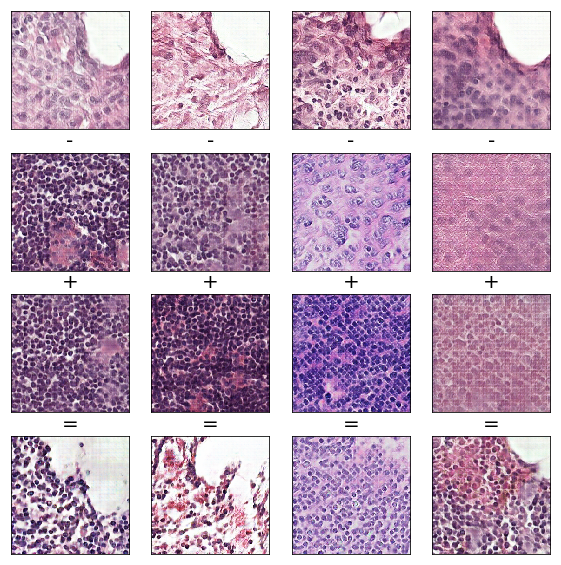

In [58]:
cancer_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__70_25_pos.txt')
cancer_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__1_9_pos.txt')
cancer_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_2_pos.txt')

all_no_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__9_10_neg.txt')
all_no_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__2_28_neg.txt')
all_no_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__5_1_pos.txt')

normal_no_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_4_neg.txt')
normal_no_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_8_neg.txt')
normal_no_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_5_neg.txt')

resultado_1 = cancer_lumen_1 - all_no_lumen_1 + normal_no_lumen_1
resultado_2 = cancer_lumen_2 - all_no_lumen_1 + normal_no_lumen_2
resultado_3 = cancer_lumen_3 - all_no_lumen_1 + normal_no_lumen_3

cancer_lumen = latent_space.average_tensor([cancer_lumen_1,cancer_lumen_2,cancer_lumen_3])
all_no_lumen = latent_space.average_tensor([all_no_lumen_1,all_no_lumen_2,all_no_lumen_3])
normal_no_lumen = latent_space.average_tensor([normal_no_lumen_1,normal_no_lumen_2,normal_no_lumen_3])

resultado =  cancer_lumen  - cancer_no_lumen + normal_no_lumen

resultados = [cancer_lumen_1,cancer_lumen_2,cancer_lumen_3,cancer_lumen,
              all_no_lumen_1,all_no_lumen_2,all_no_lumen_3,all_no_lumen,
              normal_no_lumen_1,normal_no_lumen_2,normal_no_lumen_3,normal_no_lumen,
              resultado_1,resultado_2,resultado_3,resultado]

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
labs = [1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0]
for i,img in enumerate(resultados): 
    img = np.expand_dims(img,0)
    z_ = tf.placeholder(tf.float32, [1, constants.Z_NOISE_DIM])
    labels = np.eye(2)[[labs[i]]]
    samples = session.run(dcgan.sampler(z_,input_g_y,1), feed_dict={z_: img, input_g_y:labels})
    img = np.squeeze(samples)
    subplt = plt.subplot(4, 4, i+1)
    subplt.set_title("" if i<4 else "-" if (i>3 and i<8) else "+" if (i>7 and i<12) else "=").set_fontsize(20)
    plt.imshow(img / 2 + 0.5)
    plt.xticks([])
    plt.yticks([])


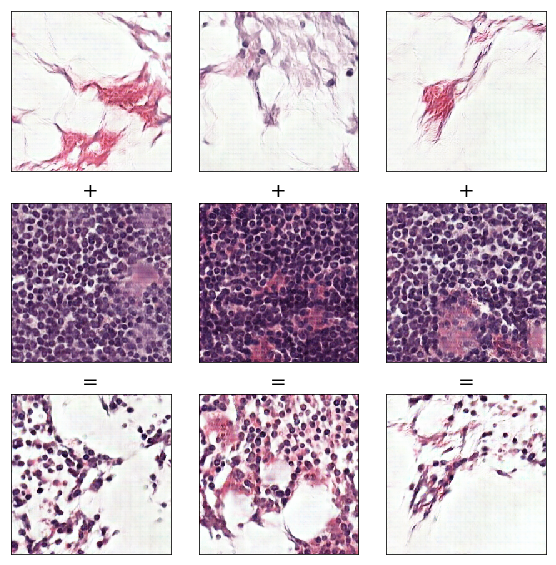

In [80]:
cancer_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__16_5_neg.txt')
cancer_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__60_15_neg.txt')
cancer_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__0_2_pos.txt')

normal_no_lumen_1 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_4_neg.txt')
normal_no_lumen_2 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__96_8_neg.txt')
normal_no_lumen_3 = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__9_10_neg.txt')

resultado_1 = cancer_lumen_1 + normal_no_lumen_1
resultado_2 = cancer_lumen_2 + normal_no_lumen_2
resultado_3 = cancer_lumen_3 + normal_no_lumen_3

resultado =  cancer_lumen + normal_no_lumen

resultados = [cancer_lumen_1,cancer_lumen_2,cancer_lumen_3,
              normal_no_lumen_1,normal_no_lumen_2,normal_no_lumen_3,
              resultado_1,resultado_2,resultado_3]

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.03)
labs = [0,0,0,0,0,0,0,0,0,0,0,0]
for i,img in enumerate(resultados): 
    img = np.expand_dims(img,0)
    z_ = tf.placeholder(tf.float32, [1, constants.Z_NOISE_DIM])
    labels = np.eye(2)[[labs[i]]]
    samples = session.run(dcgan.sampler(z_,input_g_y,1), feed_dict={z_: img, input_g_y:labels})
    img = np.squeeze(samples)
    subplt = plt.subplot(3, 3, i+1)
    subplt.set_title("" if i<3 else "+" if (i>2 and i<6) else "=").set_fontsize(20)
    plt.imshow(img / 2 + 0.5)
    plt.xticks([])
    plt.yticks([])


## Caminar por el espacio latente

In [138]:
[os.remove(file) for file in glob(constants.FULL_OUTPUT_PATH+"*interp*.png")]
punto_a = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__7_6_neg.txt')
punto_b = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__7_11_neg.txt')
punto_c = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__7_7_neg.txt')
punto_d = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__6_30_neg.txt')
latent_space.interpolate(session, punto_a, punto_b, [0,0], 2, prefix = "ac")
latent_space.interpolate(session, punto_c, punto_d, [0,0], 2, prefix = "bd")



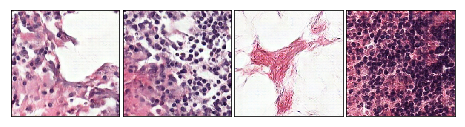

In [139]:
all_files = glob(constants.FULL_OUTPUT_PATH+"*interp*")
all_files.sort(key=natural_keys)
plt.figure(figsize=(24, 24))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i,img in enumerate(all_files):
    img = plt.imread(img)
    plt.subplot(12, 12, i+1)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])

### Interpolaciones

Otro tipo de operacion que podemos realizar es elegir dos tensores y avanzar por la "linea" que los une en el espacio latente, creando asi una interpolacion suave de imagenes intermedias. El siguiente GIF fue realizado con la version anterior entregada, consistente en un arquitectura DCGAN, como se puede ver la transicion entre un tejido sano y enfermo es suave y coherente paso a paso.

![SegmentLocal](examples/histo.gif "segment")

No sucede lo mismo en el caso de la DCGAN condicional. En este caso hemos hechos dos interpolaciones, del punto a al b y del punto b al a, pero cambiando la clase en la segunda interpolacion. Empezamos con una imagene cancerosa convertida a negativa pasamos a una negativa (normal), luega ese misma normal convertida en cancerosa y terminamos con la cancerosa.

In [55]:
[os.remove(file) for file in glob(constants.FULL_OUTPUT_PATH+"*interp*.png")]
punto_a = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__16_2_pos.txt')
punto_b = np.loadtxt(constants.FULL_OUTPUT_PATH + 'histo__41_10_neg.txt')
latent_space.interpolate(session, punto_a, punto_b, [0,0], 72, prefix = "a")
latent_space.interpolate(session, punto_b, punto_a, [1,1], 72, prefix = "b")

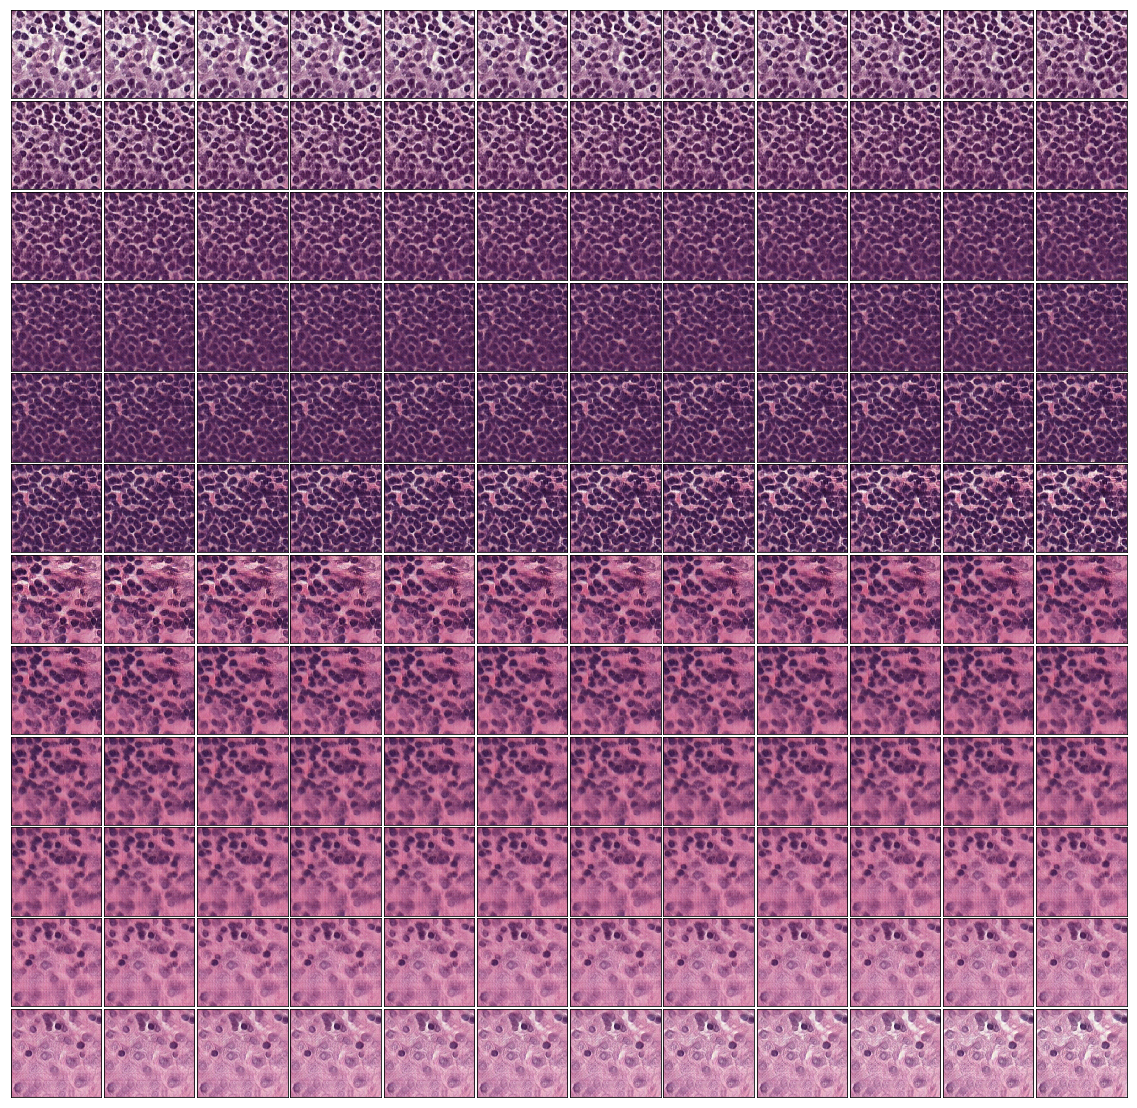

In [29]:
all_files = glob(FULL_OUTPUT_PATH+"*interp*")
all_files.sort(key=natural_keys)
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i,img in enumerate(all_files):
    img = plt.imread(img)
    plt.subplot(12, 12, i+1)
    plt.imshow(img, aspect="auto")
    plt.xticks([])
    plt.yticks([])


Como podemos observar hay un salto mas o menos abrupto al cambiar la clase. Si mantenemos la interpolacion dentro de la misma clase obtenemos una transicion continua y suave, y en el caso del siguiente gif, infinita, ya que hacemos la interpolacion hacia adelante y luego volvemos al punto de origen

In [ ]:
images = []
for filename in all_files:
    images.append(imageio.imread(filename))
imageio.mimsave('histo_cond.gif', images)

![SegmentLocal](histo_cond.gif "segment")

### Busqueda en el espacio latente

Por ultimo una pequeña demostracion de busqueda en el espacio latente. Se puede utilizar para obtener tensores de imagenes generadas o mapear imagenes reales en el espacio latente para asi una vez obtenido su tensor latente poder cambiar ciertas clases o hacer alguna de las operaciones aritmeticas que hemos visto

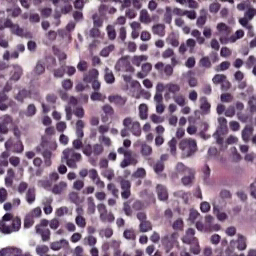

In [5]:
im = Image.open(constants.FULL_OUTPUT_PATH+"histo__46_17_neg.png")
im

In [ ]:
image = latent_space.search_image(session,im,50000)
image[0]

![SegmentLocal](examples/gen_search.png "segment")

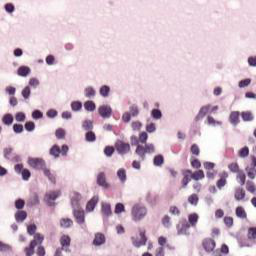

In [7]:
im = Image.open(constants.BASE_PATH + constants.DATA_PATH+"/negative/patient_010_node_4_neg_881.jpg")
im

In [ ]:
image = latent_space.search_image(session,im,100000)
image[0]

![SegmentLocal](examples/real_search.png "segment")